# Differential equations



The key to successfully solving many differential equations is correctly classifying the equations, putting them into a standard form and then picking the appropriate solver. You must be able to determine if an equation is:

-   An ordinary differential equation $Y' = f(x, Y)$ with
    -   initial values (good support in python/numpy/scipy)
    -   boundary values (not difficult to write code for simple cases)
-   Delay differential equation
-   Differential algebraic equations
-   A partial differential equation

The following sections will illustrate the methods for solving these kinds of equations.



## Ordinary differential equations



### Numerical solution to a simple ode



[Matlab post](http://matlab.cheme.cmu.edu/2011/08/03/numerical-solution-to-a-simple-ode/)

Integrate this ordinary differential equation (ode):

$$\frac{dy}{dt} = y(t)$$

over the time span of 0 to 2. The initial condition is y(0) = 1.

to solve this equation, you need to create a function of the form: dydt = f(y, t) and then use one of the odesolvers, e.g. odeint.



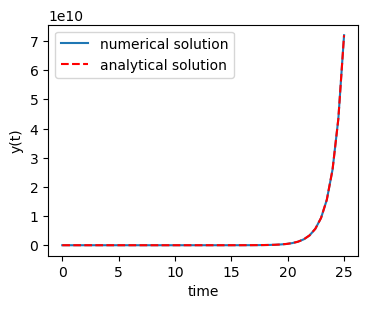

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def fprime(y,t):
    return y

tspan = np.linspace(0, 25)
y0 = 1
ysol = odeint(fprime, y0, tspan)
plt.figure(figsize=(4,3))
plt.plot(tspan, ysol, label='numerical solution')
plt.plot(tspan, np.exp(tspan), 'r--', label='analytical solution')
plt.xlabel('time')
plt.ylabel('y(t)')
plt.legend(loc='best');

The numerical and analytical solutions agree.

Now, suppose you want to know at what time is the solution equal to 3? There are several approaches to this, including setting up a solver, or using an event like approach to stop integration at y=3. A simple approach is to use reverse interpolation. We simply reverse the x and y vectors so that y is the independent variable, and we interpolate the corresponding x-value.



In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def fprime(y,t):
    return y

tspan = np.linspace(0, 2)
y0 = 1
ysol = odeint(fprime, y0, tspan)

from scipy.interpolate import interp1d

ip = interp1d(ysol[:,0], tspan) # reverse interpolation
print('y = 3 at x = {0}'.format(ip(3)))

y = 3 at x = 1.098547805640928


### Plotting ODE solutions in cylindrical coordinates



[Matlab post](http://matlab.cheme.cmu.edu/2011/11/08/plot-the-solution-to-an-ode-in-cylindrical-coordinates-2/)

It is straightforward to plot functions in Cartesian coordinates. It is less convenient to plot them in cylindrical coordinates. Here we solve an ODE in cylindrical coordinates, and then convert the solution to Cartesian coordinates for simple plotting.



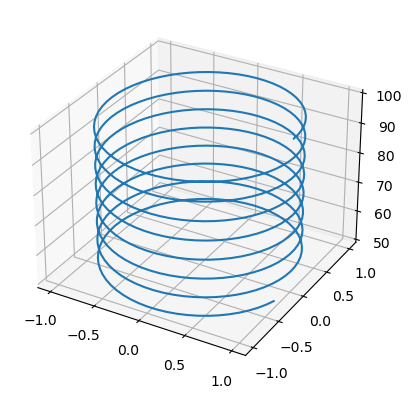

In [3]:
import numpy as np
from scipy.integrate import odeint

def dfdt(F, t):
    rho, theta, z = F
    drhodt = 0   # constant radius
    dthetadt = 1 # constant angular velocity
    dzdt = -1    # constant dropping velocity
    return [drhodt, dthetadt, dzdt]

# initial conditions
rho0 = 1
theta0 = 0
z0 = 100

tspan = np.linspace(0, 50, 500)
sol = odeint(dfdt, [rho0, theta0, z0], tspan)

rho = sol[:,0]
theta = sol[:,1]
z = sol[:,2]

# convert cylindrical coords to cartesian for plotting.
X = rho * np.cos(theta)
Y = rho * np.sin(theta)


import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(X, Y, z);

### ODEs with discontinuous forcing functions



[Matlab post](http://matlab.cheme.cmu.edu/2011/09/01/odes-with-discontinuous-forcing-functions/)

Adapted from [http://archives.math.utk.edu/ICTCM/VOL18/S046/paper.pdf](http://archives.math.utk.edu/ICTCM/VOL18/S046/paper.pdf)

A mixing tank initially contains 300 g of salt mixed into 1000 L of water. At t=0 min, a solution of 4 g/L salt enters the tank at 6 L/min. At t=10 min, the solution is changed to 2 g/L salt, still entering at 6 L/min. The tank is well stirred, and the tank solution leaves at a rate of 6 L/min. Plot the concentration of salt (g/L) in the tank as a function of time.

A mass balance on the salt in the tank leads to this differential equation: $\frac{dM_S}{dt} = \nu C_{S,in}(t) - \nu M_S/V$ with the initial condition that $M_S(t=0)=300$. The wrinkle is that the inlet conditions are not constant.

$$C_{S,in}(t) = \begin{array}{ll} 0 & t \le 0, \\ 4 & 0 < t \le 10, \\ 2 & t > 10. \end{array}$$



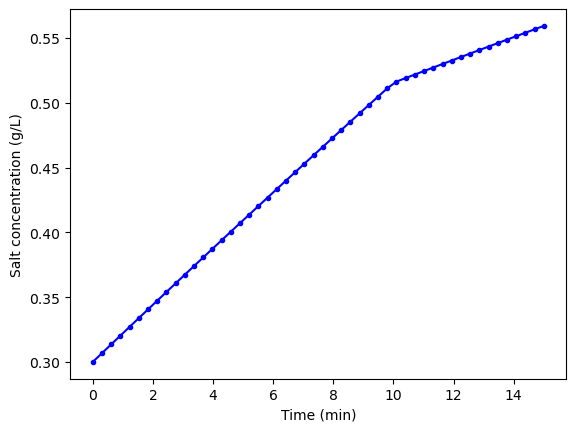

In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

V = 1000.0 # L
nu = 6.0  # L/min

def Cs_in(t):
    'inlet concentration'
    if t < 0:
        Cs = 0.0 # g/L
    elif (t > 0) and (t <= 10):
        Cs = 4.0
    else:
        Cs = 2.0
    return Cs

def mass_balance(Ms, t):
    '$\frac{dM_S}{dt} = \nu C_{S,in}(t) - \nu M_S/V$'
    dMsdt = nu * Cs_in(t) - nu * Ms / V
    return dMsdt

tspan = np.linspace(0.0, 15.0, 50)

M0 = 300.0 # gm salt
Ms = odeint(mass_balance, M0, tspan)

plt.plot(tspan, Ms/V, 'b.-')
plt.xlabel('Time (min)')
plt.ylabel('Salt concentration (g/L)');

You can see the discontinuity in the salt concentration at 10 minutes due to the discontinous change in the entering salt concentration.



### Simulating the events feature of Matlab's ode solvers



The ode solvers in Matlab allow you create functions that define events that can stop the integration, detect roots, etc&#x2026; We will explore how to get a similar effect in python. Here is an example that somewhat does this, but it is only an approximation. We will manually integrate the ODE, adjusting the time step in each iteration to zero in on the solution. When the desired accuracy is reached, we stop the integration.

<span class="timestamp-wrapper"><span class="timestamp">[2023-06-08 Thu] </span></span> events are now supported in scipy.integrate.solve\_ivp.



Solution reached at i = 15
At t=2.46  Ca = 1.000


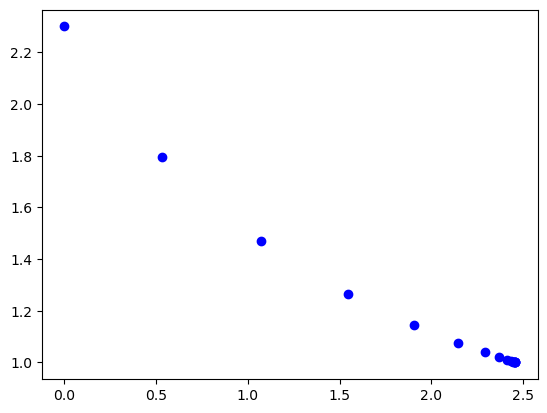

In [5]:
import numpy as np
from scipy.integrate import odeint

def dCadt(Ca, t):
    "the ode function"
    k = 0.23
    return -k * Ca**2

Ca0 = 2.3

# create lists to store time span and solution
tspan = [0, ]
sol = [Ca0,]
i = 0

while i < 100:   # take max of 100 steps
    t1 = tspan[i]
    Ca = sol[i]

    # pick the next time using a Newton-Raphson method
    # we want f(t, Ca) = (Ca(t) - 1)**2 = 0
    # df/dt = df/dCa dCa/dt
    #       = 2*(Ca - 1) * dCadt
    t2 = t1 - (Ca - 1.0)**2 / (2 * (Ca - 1) *dCadt(Ca, t1))

    f = odeint(dCadt, Ca, [t1, t2])

    if np.abs(Ca - 1.0) <= 1e-4:
        print('Solution reached at i = {0}'.format(i))
        break

    tspan += [t2]
    sol.append(f[-1][0])
    i += 1

print('At t={0:1.2f}  Ca = {1:1.3f}'.format(tspan[-1], sol[-1]))

import matplotlib.pyplot as plt
plt.plot(tspan, sol, 'bo');

This particular solution works for this example, probably because it is well behaved. It is "downhill" to the desired solution. It is not obvious this would work for every example, and it is certainly possible the algorithm could go "backward" in time. A better approach might be to integrate forward until you detect a sign change in your event function, and then refine it in a separate loop.

I like the events integration in Matlab better, but this is actually pretty functional. It should not be too hard to use this for root counting, e.g. by counting sign changes. It would be considerably harder to get the actual roots. It might also be hard to get the positions of events that include the sign or value of the derivatives at the event points.

ODE solving in Matlab is considerably more advanced in functionality than in scipy. There do seem to be some extra packages, e.g. pydstools, scikits.odes that add extra ode functionality.



### Mimicking ode events in python



The ODE functions in scipy.integrate do not directly support events like the functions in Matlab do. We can achieve something like it though, by digging into the guts of the solver, and writing a little code. In  previous [example](http://matlab.cheme.cmu.edu/2011/09/10/counting-roots/) I used an event to count the number of roots in a function by integrating the derivative of the function.



x = -6.000000064427786, event = -4.6351811278100286e-15, f = -4.6351811278100286e-15
x = -1.9999999623352622, event = -1.4051260155411128e-15, f = -1.4051260155411128e-15
x = 1.999999886950595, event = -1.1102230246251565e-15, f = -1.1102230246251565e-15


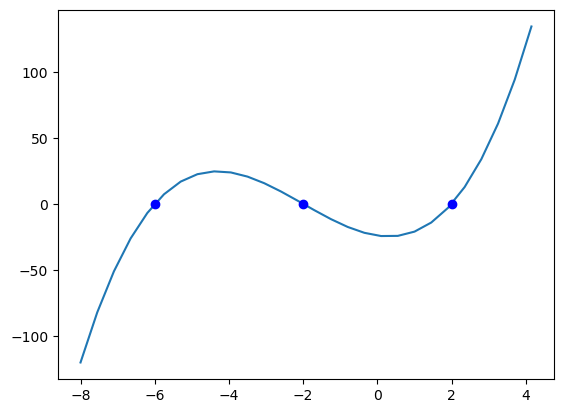

In [6]:
import numpy as np
from scipy.integrate import odeint

def myode(f, x):
    return 3*x**2 + 12*x -4

def event(f, x):
    'an event is when f = 0'
    return f

# initial conditions
x0 = -8
f0 = -120

# final x-range and step to integrate over.
xf = 4   #final x value
deltax = 0.45 #xstep

# lists to store the results in
X = [x0]
sol = [f0]
e = [event(f0, x0)]
events = []
x2 = x0
# manually integrate at each time step, and check for event sign changes at each step
while x2 <= xf: #stop integrating when we get to xf
    x1 = X[-1]
    x2 = x1 + deltax
    f1 = sol[-1]

    f2 = odeint(myode, f1, [x1, x2]) # integrate from x1,f1 to x2,f2
    X += [x2]
    sol += [f2[-1][0]]

    # now evaluate the event at the last position
    e += [event(sol[-1], X[-1])]

    if e[-1] * e[-2] < 0:
        # Event detected where the sign of the event has changed. The
        # event is between xPt = X[-2] and xLt = X[-1]. run a modified bisect
        # function to narrow down to find where event = 0
        xLt = X[-1]
        fLt = sol[-1]
        eLt = e[-1]

        xPt = X[-2]
        fPt = sol[-2]
        ePt = e[-2]

        j = 0
        while j < 100:
            if np.abs(xLt - xPt) < 1e-6:
                # we know the interval to a prescribed precision now.
                print('x = {0}, event = {1}, f = {2}'.format(xLt, eLt, fLt))
                events += [(xLt, fLt)]
                break # and return to integrating

            m = (ePt - eLt)/(xPt - xLt) #slope of line connecting points
                                        #bracketing zero

            #estimated x where the zero is
            new_x = -ePt / m + xPt

            # now get the new value of the integrated solution at that new x
            f  = odeint(myode, fPt, [xPt, new_x])
            new_f = f[-1][-1]
            new_e = event(new_f, new_x)

            # now check event sign change
            if eLt * new_e > 0:
                xPt = new_x
                fPt = new_f
                ePt = new_e
            else:
                xLt = new_x
                fLt = new_f
                eLt = new_e

            j += 1


import matplotlib.pyplot as plt
plt.plot(X, sol)

# add event points to the graph
for x,e in events:
    plt.plot(x,e,'bo ')

That was a lot of programming to do something like find the roots of the function! Today I would use solve\_ivp for this.



### Solving an ode for a specific solution value



[Matlab post](http://matlab.cheme.cmu.edu/2011/08/31/solving-an-ode-for-a-specific-solution-value/)
The analytical solution to an ODE is a function, which can be solved to get a particular value, e.g. if the solution to an ODE is y(x) = exp(x), you can solve the solution to find the value of x that makes $y(x)=2$. In a numerical solution to an ODE we get a vector of independent variable values, and the corresponding function values at those values. To solve for a particular function value we need a different approach. This post will show one way to do that in python.

Given that the concentration of a species A in a constant volume, batch reactor obeys this differential equation $\frac{dC_A}{dt}=- k C_A^2$ with the initial condition $C_A(t=0) = 2.3$ mol/L and $k = 0.23$ L/mol/s, compute the time it takes for $C_A$ to be reduced to 1 mol/L.

We will get a solution, then create an interpolating function and use fsolve to get the answer. 



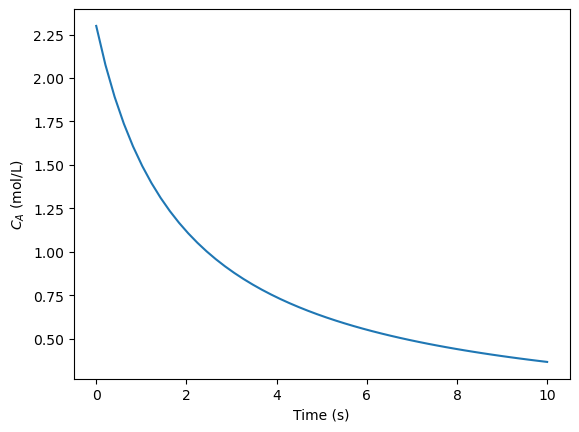

In [7]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt

k = 0.23
Ca0 = 2.3

def dCadt(Ca, t):
    return -k * Ca**2

tspan = np.linspace(0, 10)

sol = odeint(dCadt, Ca0, tspan)
Ca = sol[:,0]

plt.plot(tspan, Ca)
plt.xlabel('Time (s)')
plt.ylabel('$C_A$ (mol/L)');

You can see the solution is near two seconds. Now we create an interpolating function to evaluate the solution. We will plot the interpolating function on a finer grid to make sure it seems reasonable.



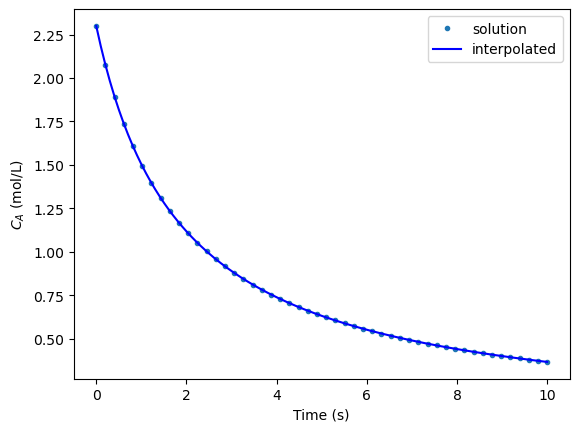

In [8]:
ca_func = interp1d(tspan, Ca, 'cubic')

itime = np.linspace(0, 10, 200)

plt.figure()
plt.plot(tspan, Ca, '.')
plt.plot(itime, ca_func(itime), 'b-')

plt.xlabel('Time (s)')
plt.ylabel('$C_A$ (mol/L)')
plt.legend(['solution','interpolated']);

that looks pretty reasonable. Now we solve the problem.



In [9]:
tguess = 2.0
tsol, = fsolve(lambda t: 1.0 - ca_func(t), tguess)
print(tsol)

# you might prefer an explicit function
def func(t):
    return 1.0 - ca_func(t)

tsol2, = fsolve(func, tguess)
print(tsol2)

2.4574668234994665
2.4574668234994665


That is it. Interpolation can provide a simple way to evaluate the numerical solution of an ODE at other values.

For completeness we examine a final way to construct the function. We can actually integrate the ODE in the function to evaluate the solution at the point of interest. If it is not computationally expensive to evaluate the ODE solution this works fine. Note, however, that the ODE will get integrated from 0 to the value t for each iteration of fsolve.



In [10]:
def func(t):
    tspan = [0, t]
    sol = odeint(dCadt, Ca0, tspan)
    return (1.0 - sol[-1])[0]

tsol3, = fsolve(func, tguess)
print(tsol3)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

### A simple first order ode evaluated at specific points



[Matlab post](http://matlab.cheme.cmu.edu/2011/08/05/a-simple-first-order-ode-evaluated-at-specific-points/)

We have integrated an ODE over a specific time span. Sometimes it is desirable to get the solution at specific points, e.g. at t = [0 0.2 0.4 0.8]; This could be desirable to compare with experimental measurements at those time points. This example demonstrates how to do that.

$$\frac{dy}{dt} = y(t)$$

The initial condition is y(0) = 1.



In [ ]:
from scipy.integrate import odeint

y0 = 1
tspan = [0, 0.2, 0.4, 0.8]

def dydt(y, t):
    return y

Y = odeint(dydt, y0, tspan)
print(Y[:,0])

### Error tolerance in numerical solutions to ODEs



[Matlab post](http://matlab.cheme.cmu.edu/2011/09/18/error-tolerance-in-numerical-solutions-to-odes/)

Usually, the numerical ODE solvers in python work well with the standard settings. Sometimes they do not, and it is not always obvious they have not worked! Part of using a tool like python is checking how well your solution really worked. We use an example of integrating an ODE that defines the van der Waal equation of an ideal gas here.

we plot the analytical solution to the van der waal equation in reduced form here.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Tr = 0.9
Vr = np.linspace(0.34,4,1000)

#analytical equation for Pr
Prfh = lambda Vr: 8.0 / 3.0 * Tr / (Vr - 1.0 / 3.0) - 3.0 / (Vr**2)
Pr = Prfh(Vr) # evaluated on our reduced volume vector.

# Plot the EOS
plt.clf()
plt.plot(Vr,Pr)
plt.ylim([0, 2])
plt.xlabel('$V_R$')
plt.ylabel('$P_R$');

we want an equation for dPdV, which we will integrate we use symbolic math to do the derivative for us.



In [ ]:
from sympy import diff, Symbol
Vrs = Symbol('Vrs')

Prs = 8.0 / 3.0 * Tr / (Vrs - 1.0/3.0) - 3.0/(Vrs**2)
print(diff(Prs,Vrs))

Now, we solve the ODE. We will specify a large relative tolerance criteria (Note the default is much smaller than what we show here).



In [ ]:
from scipy.integrate import odeint

def myode(Pr, Vr):
    dPrdVr = -2.4/(Vr - 0.333333333333333)**2 + 6.0/Vr**3
    return dPrdVr

Vspan = np.linspace(0.334, 4)
Po = Prfh(Vspan[0])
P = odeint(myode, Po, Vspan, rtol=1e-4)

# Plot the EOS
plt.plot(Vr,Pr) # analytical solution
plt.plot(Vspan, P[:,0], 'r.')
plt.ylim([0, 2])
plt.xlabel('$V_R$')
plt.ylabel('$P_R$');

You can see there is disagreement between the analytical solution and numerical solution. The origin of this problem is accuracy at the initial condition, where the derivative is extremely large.



In [ ]:
print(myode(Po, 0.34))

We can increase the tolerance criteria to get a better answer. The defaults in odeint are actually set to 1.49012e-8.



In [ ]:
Vspan = np.linspace(0.334, 4)
Po = Prfh(Vspan[0])
P = odeint(myode, Po, Vspan)

# Plot the EOS
plt.clf()
plt.plot(Vr,Pr) # analytical solution
plt.plot(Vspan, P[:,0], 'r.')
plt.ylim([0, 2])
plt.xlabel('$V_R$')
plt.ylabel('$P_R$');

The problem here was the derivative value varied by four orders of magnitude over the integration range, so the default tolerances were insufficient to accurately estimate the numerical derivatives over that range. Tightening the tolerances helped resolve that problem. Another approach might be to split the integration up into different regions. For instance, if instead of starting at Vr = 0.34, which is very close to a sigularity in the van der waal equation at Vr = 1/3, if you start at Vr = 0.5, the solution integrates just fine with the standard tolerances.



### Solving parameterized ODEs over and over conveniently



[Matlab post](http://matlab.cheme.cmu.edu/2011/09/16/parameterized-odes/)

Sometimes we have an ODE that depends on a parameter, and we want to solve the ODE for several parameter values. It is inconvenient to write an ode function for each parameter case. Here we examine a convenient way to solve this problem; we pass the parameter to the ODE at runtime. We consider the following ODE:

$$\frac{dCa}{dt} = -k Ca(t)$$

where $k$ is a parameter, and we want to solve the equation for a couple of values of $k$ to test the sensitivity of the solution on the parameter. Our question is, given $Ca(t=0)=2$, how long does it take to get $Ca = 1$, and how sensitive is the answer to small variations in $k$?



In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def myode(Ca, t, k):
    'ODE definition'
    dCadt = -k * Ca
    return dCadt

tspan = np.linspace(0, 0.5)
k0 = 2
Ca0 = 2

plt.figure(); plt.clf()

for k in [0.95 * k0, k0, 1.05 * k0]:
    sol = odeint(myode, Ca0, tspan, args=(k,))
    plt.plot(tspan, sol, label='k={0:1.2f}'.format(k))
    print('At t=0.5 Ca = {0:1.2f} mol/L'.format(sol[-1][0]))

plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('$C_A$ (mol/L)');

You can see there are some variations in the concentration at t = 0.5. You could over or underestimate the concentration if you have the wrong estimate of $k$! You have to use some judgement here to decide how long to run the reaction to ensure a target goal is met.



### Yet another way to parameterize an ODE



[Matlab post](http://matlab.cheme.cmu.edu/2011/11/06/yet-another-way-to-parameterize-an-ode/)

We previously examined a way to parameterize an ODE. In those methods, we either used an anonymous function to parameterize an ode function, or we used a nested function that used variables from the shared workspace.

We want a convenient way to solve $dCa/dt = -k Ca$ for multiple values of $k$. Here we use a trick to pass a parameter to an ODE through the initial conditions. We expand the ode function definition to include this parameter, and set its derivative to zero, effectively making it a constant.



In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def ode(F, t):
    Ca, k = F
    dCadt = -k * Ca
    dkdt = 0.0
    return [dCadt, dkdt]

tspan = np.linspace(0, 4)

Ca0 = 1;
K = [2.0, 3.0]
for k in K:
    F = odeint(ode, [Ca0, k], tspan)
    Ca = F[:,0]
    plt.plot(tspan, Ca, label='k={0}'.format(k))
plt.xlabel('time')
plt.ylabel('$C_A$')
plt.legend(loc='best');

I do not think this is a very elegant way to pass parameters around compared to the previous methods, but it nicely illustrates that there is more than one way to do it. And who knows, maybe it will be useful in some other context one day!



### Another way to parameterize an ODE - nested function



[Matlab post](http://matlab.cheme.cmu.edu/2011/09/18/another-way-to-parameterize-an-ode-nested-function/)

We saw one method to parameterize an ODE, by creating an ode function that takes an extra parameter argument, and then making a function handle that has the syntax required for the solver, and passes the parameter the ode function.

Here we define the ODE function in a loop. Since the nested function is in the namespace of the main function, it can "see" the values of the variables in the main function. We will use this method to look at the solution to the van der Pol equation for several different values of mu.



In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

MU = [0.1, 1, 2, 5]
tspan = np.linspace(0, 100, 5000)
Y0 = [0, 3]

for mu in MU:
    # define the ODE
    def vdpol(Y, t):
        x,y = Y
        dxdt = y
        dydt = -x + mu * (1 - x**2) * y
        return  [dxdt, dydt]

    Y = odeint(vdpol, Y0, tspan)

    x = Y[:,0]; y = Y[:,1]
    plt.plot(x, y, label='mu={0:1.2f}'.format(mu))

plt.axis('equal')
plt.legend(loc='best');

You can see the solution changes dramatically for different values of mu. The point here is not to understand why, but to show an easy way to study a parameterize ode with a nested function. Nested functions can be a great way to "share" variables between functions especially for ODE solving, and nonlinear algebra solving, or any other application where you need a lot of parameters defined in one function in another function.



### Solving a second order ode



[Matlab post](http://matlab.cheme.cmu.edu/2011/09/26/solving-a-second-order-ode/)


The odesolvers in scipy can only solve first order ODEs, or systems of first order ODES. To solve a second order ODE, we must convert it by changes of variables to a system of first order ODES. We consider the Van der Pol oscillator here:

$$\frac{d^2x}{dt^2} - \mu(1-x^2)\frac{dx}{dt} + x = 0$$

$\mu$ is a constant. If we let $y=x - x^3/3$ [http://en.wikipedia.org/wiki/Van_der_Pol_oscillator](http://en.wikipedia.org/wiki/Van_der_Pol_oscillator), then we arrive at this set of equations:

$$\frac{dx}{dt} = \mu(x-1/3x^3-y)$$

$$\frac{dy}{dt} = \mu/x$$

here is how we solve this set of equations. Let $\mu=1$.



In [ ]:
from scipy.integrate import odeint
import numpy as np

mu = 1.0

def vanderpol(X, t):
    x = X[0]
    y = X[1]
    dxdt = mu * (x - 1./3.*x**3 - y)
    dydt = x / mu
    return [dxdt, dydt]

X0 = [1, 2]
t = np.linspace(0, 40, 250)

sol = odeint(vanderpol, X0, t)

import matplotlib.pyplot as plt
x = sol[:, 0]
y = sol[:, 1]

plt.plot(t,x, t, y)
plt.xlabel('t')
plt.legend(('x', 'y'))

# phase portrait
plt.figure()
plt.plot(x,y)
plt.plot(x[0], y[0], 'ro')
plt.xlabel('x')
plt.ylabel('y');

Here is the phase portrait. You can see that a limit cycle is approached, indicating periodicity in the solution.



### Solving Bessel's Equation numerically



[Matlab post](http://matlab.cheme.cmu.edu/2011/08/08/solving-bessels-equation-numerically/)

Reference Ch 5.5 Kreysig, Advanced Engineering Mathematics, 9th ed.

Bessel's equation $x^2 y'' + x y' + (x^2 - \nu^2)y=0$ comes up often in engineering problems such as heat transfer. The solutions to this equation are the Bessel functions. To solve this equation numerically, we must convert it to a system of first order ODEs. This can be done by letting $z = y'$ and $z' = y''$ and performing the change of variables:

$$ y' = z$$

$$ z' = \frac{1}{x^2}(-x z - (x^2 - \nu^2) y$$

if we take the case where $\nu = 0$, the solution is known to be the Bessel function $J_0(x)$, which is represented in Matlab as besselj(0,x). The initial conditions for this problem are: $y(0) = 1$ and $y'(0)=0$.

There is a problem with our system of ODEs at x=0. Because of the $1/x^2$ term, the ODEs are not defined at x=0. If we start very close to zero instead, we avoid the problem.



In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.special import jn # bessel function
import matplotlib.pyplot as plt

def fbessel(Y, x):
    nu = 0.0
    y = Y[0]
    z = Y[1]

    dydx = z
    dzdx = 1.0 / x**2 * (-x * z - (x**2 - nu**2) * y)
    return [dydx, dzdx]

x0 = 1e-15
y0 = 1
z0 = 0
Y0 = [y0, z0]

xspan = np.linspace(1e-15, 10)
sol = odeint(fbessel, Y0, xspan)

plt.plot(xspan, sol[:,0], label='numerical soln')
plt.plot(xspan, jn(0, xspan), 'r--', label='Bessel')
plt.legend();

You can see the numerical and analytical solutions overlap, indicating they are at least visually the same.



### Phase portraits of a system of ODEs



[Matlab post](http://matlab.cheme.cmu.edu/2011/08/09/phase-portraits-of-a-system-of-odes/)
An undamped pendulum with no driving force is described by

$$ y'' + sin(y) = 0$$

We reduce this to standard matlab form of a system of first order ODEs by letting $y_1 = y$ and $y_2=y_1'$. This leads to:

$y_1' = y_2$

$y_2' = -sin(y_1)$

The phase portrait is a plot of a vector field which qualitatively shows how the solutions to these equations will go from a given starting point. here is our definition of the differential equations:

To generate the phase portrait, we need to compute the derivatives $y_1'$ and $y_2'$ at $t=0$ on a grid over the range of values for $y_1$ and $y_2$ we are interested in. We will plot the derivatives as a vector at each (y1, y2) which will show us the initial direction from each point. We will examine the solutions over the range -2 < y1 < 8, and -2 < y2 < 2 for y2, and create a grid of 20 x 20 points.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def f(Y, t):
    y1, y2 = Y
    return [y2, -np.sin(y1)]

y1 = np.linspace(-2.0, 8.0, 20)
y2 = np.linspace(-2.0, 2.0, 20)

Y1, Y2 = np.meshgrid(y1, y2)

t = 0

u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

NI, NJ = Y1.shape

for i in range(NI):
    for j in range(NJ):
        x = Y1[i, j]
        y = Y2[i, j]
        yprime = f([x, y], t)
        u[i,j] = yprime[0]
        v[i,j] = yprime[1]


Q = plt.quiver(Y1, Y2, u, v, color='r')

plt.xlabel('$y_1$')
plt.ylabel('$y_2$')
plt.xlim([-2, 8])
plt.ylim([-4, 4]);

Let us plot a few solutions on the vector field. We will consider the solutions where y1(0)=0, and values of y2(0) = [0 0.5 1 1.5 2 2.5], in otherwords we start the pendulum at an angle of zero, with some angular velocity.



In [ ]:
from scipy.integrate import odeint

plt.clf()
for y20 in [0, 0.5, 1, 1.5, 2, 2.5]:
    tspan = np.linspace(0, 50, 200)
    y0 = [0.0, y20]
    ys = odeint(f, y0, tspan)
    plt.plot(ys[:,0], ys[:,1], 'b-') # path
    plt.plot([ys[0,0]], [ys[0,1]], 'o') # start
    plt.plot([ys[-1,0]], [ys[-1,1]], 's') # end


plt.xlim([-2, 8]);

What do these figures mean? For starting points near the origin, and small velocities, the pendulum goes into a stable limit cycle. For others, the trajectory appears to fly off into y1 space. Recall that y1 is an angle that has values from $-\pi$ to $\pi$. The y1 data in this case is not wrapped around to be in this range.



### Linear algebra approaches to solving systems of constant coefficient ODEs



[Matlab post](http://matlab.cheme.cmu.edu/2011/10/20/linear-algebra-approaches-to-solving-systems-of-constant-coefficient-odes)

Today we consider how to solve a system of first order, constant coefficient ordinary differential equations using linear algebra. These equations could be solved numerically, but in this case there are analytical solutions that can be derived. The equations we will solve are:

$y'_1 = -0.02 y_1 + 0.02 y_2$

$y'_2 = 0.02 y_1 - 0.02 y_2$

We can express this set of equations in matrix form as: $\left[\begin{array}{c}y'_1\\y'_2\end{array}\right] = \left[\begin{array}{cc} -0.02 & 0.02 \\ 0.02 & -0.02\end{array}\right] \left[\begin{array}{c}y_1\\y_2\end{array}\right]$

The general solution to this set of equations is

$\left[\begin{array}{c}y_1\\y_2\end{array}\right] = \left[\begin{array}{cc}v_1 & v_2\end{array}\right] \left[\begin{array}{cc} c_1 & 0 \\ 0 & c_2\end{array}\right] \exp\left(\left[\begin{array}{cc} \lambda_1 & 0 \\ 0 & \lambda_2\end{array}\right] \left[\begin{array}{c}t\\t\end{array}\right]\right)$

where $\left[\begin{array}{cc} \lambda_1 & 0 \\ 0 & \lambda_2\end{array}\right]$ is a diagonal matrix of the eigenvalues of the constant coefficient matrix, $\left[\begin{array}{cc}v_1 & v_2\end{array}\right]$ is a matrix of eigenvectors where the $i^{th}$ column corresponds to the eigenvector of the $i^{th}$ eigenvalue, and $\left[\begin{array}{cc} c_1 & 0 \\ 0 & c_2\end{array}\right]$ is a matrix determined by the initial conditions.

In this example, we evaluate the solution using linear algebra. The initial conditions we will consider are $y_1(0)=0$ and $y_2(0)=150$.



In [ ]:
import numpy as np

A = np.array([[-0.02,  0.02],
              [ 0.02, -0.02]])

# Return the eigenvalues and eigenvectors of a Hermitian or symmetric matrix.
evals, evecs = np.linalg.eigh(A)
print(evals)
print(evecs)

The eigenvectors are the *columns* of evecs.

Compute the $c$ matrix

V\*c = Y0



In [ ]:
Y0 = [0, 150]

c = np.diag(np.linalg.solve(evecs, Y0))
print(c)

Constructing the solution

We will create a vector of time values, and stack them for each solution, $y_1(t)$ and $Y_2(t)$.



In [ ]:
import matplotlib.pyplot as plt

t = np.linspace(0, 100)
T = np.row_stack([t, t])

D = np.diag(evals)

# y = V*c*exp(D*T);
y = np.dot(np.dot(evecs, c), np.exp(np.dot(D, T)))

# y has a shape of (2, 50) so we have to transpose it
plt.plot(t, y.T)
plt.xlabel('t')
plt.ylabel('y')
plt.legend(['$y_1$', '$y_2$']);

## Delay Differential Equations



In Matlab you can solve Delay Differential equations (DDE) ([Matlab post](http://matlab.cheme.cmu.edu/2011/09/28/delay-differential-equations/)). I do not know of a solver in scipy at this time that can do this.



## Differential algebraic systems of equations



There is not a builtin solver for DAE systems in scipy. It looks like [pysundials](http://pysundials.sourceforge.net/) may do it, but it must be compiled and installed.



## Boundary value equations



In the following examples we implement some approaches to solving certain types of linear BVPs.

scipy.integrate.solve\_bvp now exists.



### Plane Poiseuille flow - BVP solve by shooting method



[Matlab post](http://matlab.cheme.cmu.edu/2011/09/08/plane-poiseuille-flow-bvp-solve-by-shooting-method/)

One approach to solving BVPs is to use the shooting method. The reason we cannot use an initial value solver for a BVP is that there is not enough information at the initial value to start. In the shooting method, we take the function value at the initial point, and guess what the function derivatives are so that we can do an integration. If our guess was good, then the solution will go through the known second boundary point. If not, we guess again, until we get the answer we need. In this example we repeat the pressure driven flow example, but illustrate the shooting method.

In the pressure driven flow of a fluid with viscosity $\mu$ between two stationary plates separated by distance $d$ and driven by a pressure drop $\Delta P/\Delta x$, the governing equations on the velocity $u$ of the fluid are (assuming flow in the x-direction with the velocity varying only in the y-direction):

$$\frac{\Delta P}{\Delta x} = \mu \frac{d^2u}{dy^2}$$

with boundary conditions $u(y=0) = 0$ and $u(y=d) = 0$, i.e. the no-slip condition at the edges of the plate.

we convert this second order BVP to a system of ODEs by letting $u_1 = u$, $u_2 = u_1'$ and then $u_2' = u_1''$. This leads to:

$\frac{d u_1}{dy} = u_2$

$\frac{d u_2}{dy} = \frac{1}{\mu}\frac{\Delta P}{\Delta x}$

with boundary conditions $u_1(y=0) = 0$ and $u_1(y=d) = 0$.

for this problem we let the plate separation be d=0.1, the viscosity $\mu = 1$, and $\frac{\Delta P}{\Delta x} = -100$.



#### First guess



We need u\_1(0) and u\_2(0), but we only have u\_1(0). We need to guess a value for u\_2(0) and see if the solution goes through the u\_2(d)=0 boundary value.



In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

d = 0.1 # plate thickness

def odefun(U, y):
    u1, u2 = U
    mu = 1
    Pdrop = -100
    du1dy = u2
    du2dy = 1.0 / mu * Pdrop
    return [du1dy, du2dy]

u1_0 = 0 # known
u2_0 = 1 # guessed

dspan = np.linspace(0, d)

U = odeint(odefun, [u1_0, u2_0], dspan)

plt.plot(dspan, U[:,0])
plt.plot([d],[0], 'ro')
plt.xlabel('d')
plt.ylabel('$u_1$');

Here we have undershot the boundary condition. Let us try a larger guess.



#### Second guess



In [ ]:
u1_0 = 0 # known
u2_0 = 10 # guessed

dspan = np.linspace(0, d)

U = odeint(odefun, [u1_0, u2_0], dspan)

plt.plot(dspan, U[:,0])
plt.plot([d],[0], 'ro')
plt.xlabel('d')
plt.ylabel('$u_1$');

Now we have clearly overshot. Let us now make a function that will iterate for us to find the right value.



#### Let fsolve do the work



In [ ]:
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

Pdrop = -100

def objective(u2_0):
    dspan = np.linspace(0, d)
    U = odeint(odefun, [u1_0, u2_0], dspan)
    u1 = U[:,0]
    return u1[-1]

u2_0, = fsolve(objective, 1.0)

# now solve with optimal u2_0
U = odeint(odefun, [u1_0, u2_0], dspan)

plt.plot(dspan, U[:,0], label='Numerical solution')
plt.plot([d],[0], 'ro')

# plot an analytical solution
u = -(Pdrop) * d**2 / 2 / mu * (dspan / d - (dspan / d)**2)
plt.plot(dspan, u, 'r--', label='Analytical solution')


plt.xlabel('d')
plt.ylabel('$u_1$')
plt.legend(loc='best');

You can see the agreement is excellent!



### Plane poiseuelle flow solved by finite difference



[Matlab post](http://matlab.cheme.cmu.edu/2011/09/30/plane-poiseuelle-flow-solved-by-finite-difference/)

Adapted from [http://www.physics.arizona.edu/~restrepo/475B/Notes/sourcehtml/node24.html](http://www.physics.arizona.edu/~restrepo/475B/Notes/sourcehtml/node24.html)

We want to solve a linear boundary value problem of the form: y'' = p(x)y' + q(x)y + r(x) with boundary conditions y(x1) = alpha and y(x2) = beta.

For this example, we solve the plane poiseuille flow problem using a finite difference approach. An advantage of the approach we use here is we do not have to rewrite the second order ODE as a set of coupled first order ODEs, nor do we have to provide guesses for the solution. We do, however, have to discretize the derivatives and formulate a linear algebra problem.

we want to solve u'' = 1/mu\*DPDX with u(0)=0 and u(0.1)=0. for this problem we let the plate separation be d=0.1, the viscosity $\mu = 1$, and $\frac{\Delta P}{\Delta x} = -100$.

The idea behind the finite difference method is to approximate the derivatives by finite differences on a grid. See here for details. By discretizing the ODE, we arrive at a set of linear algebra equations of the form $A y = b$, where $A$ and $b$ are defined as follows.

$$A = \left [ \begin{array}{ccccc} %
 2 + h^2 q_1         & -1 + \frac{h}{2} p_1 & 0                    & 0 & 0 \\
-1 - \frac{h}{2} p_2 & 2 + h^2 q_2          & -1 + \frac{h}{2} p_2 & 0 & 0 \\
0                    & \ddots               & \ddots               & \ddots & 0 \\
0                    & 0                    & -1 - \frac{h}{2} p_{N-1} & 2 + h^2 q_{N-1} & -1 + \frac{h}{2} p_{N-1} \\
0                    & 0                    & 0  & -1 - \frac{h}{2} p_N & 2 + h^2 q_N \end{array} \right ] $$

$$ y = \left [ \begin{array}{c} y_i \\ \vdots \\ y_N \end{array} \right ] $$

$$ b = \left [ \begin{array}{c} -h^2 r_1 + ( 1 + \frac{h}{2} p_1) \alpha \\
-h^2 r_2 \\
\vdots \\
-h^2 r_{N-1} \\
-h^2 r_N + (1 - \frac{h}{2} p_N) \beta \end{array} \right] $$



In [ ]:
import numpy as np

# we use the notation for y'' = p(x)y' + q(x)y + r(x)
def p(x):
    return 0

def q(x):
    return 0

def r(x):
    return -100

#we use the notation y(x1) = alpha and y(x2) = beta

x1 = 0; alpha = 0.0
x2 = 0.1; beta = 0.0

npoints = 100

# compute interval width
h = (x2-x1)/npoints;

# preallocate and shape the b vector and A-matrix
b = np.zeros((npoints - 1, 1));
A = np.zeros((npoints - 1, npoints - 1));
X = np.zeros((npoints - 1, 1));

#now we populate the A-matrix and b vector elements
for i in range(npoints - 1):
    X[i,0] = x1 + (i + 1) * h

    # get the value of the BVP Odes at this x
    pi = p(X[i])
    qi = q(X[i])
    ri = r(X[i])

    if i == 0:
        # first boundary condition
        b[i] = -h**2 * ri + (1 + h / 2 * pi)*alpha;
    elif i == npoints - 1:
        # second boundary condition
        b[i] = -h**2 * ri + (1 - h / 2 * pi)*beta;
    else:
        b[i] = -h**2 * ri # intermediate points

    for j in range(npoints - 1):
        if j == i: # the diagonal
            A[i,j] = 2 + h**2 * qi
        elif j == i - 1: # left of the diagonal
            A[i,j] = -1 - h / 2 * pi
        elif j == i + 1: # right of the diagonal
            A[i,j] = -1 + h / 2 * pi
        else:
            A[i,j] = 0 # off the tri-diagonal

# solve the equations A*y = b for Y
Y = np.linalg.solve(A,b)

x = np.hstack([x1, X[:,0], x2])
y = np.hstack([alpha, Y[:,0], beta])

import matplotlib.pyplot as plt

plt.plot(x, y)

mu = 1
d = 0.1
x = np.linspace(0,0.1);
Pdrop = -100 # this is DeltaP/Deltax
u = -(Pdrop) * d**2 / 2.0 / mu * (x / d - (x / d)**2)
plt.plot(x,u,'r--')

plt.xlabel('distance between plates')
plt.ylabel('fluid velocity')
plt.legend(('finite difference', 'analytical soln'));

You can see excellent agreement here between the numerical and analytical solution.



### Boundary value problem in heat conduction



[Matlab post](http://matlab.cheme.cmu.edu/2011/08/11/boundary-value-problem-in-heat-conduction/)

For steady state heat conduction the temperature distribution in one-dimension is governed by the Laplace equation:

$$ \nabla^2 T = 0$$

with boundary conditions that at $T(x=a) = T_A$ and $T(x=L) = T_B$.

The analytical solution is not difficult here: $T = T_A-\frac{T_A-T_B}{L}x$, but we will solve this by finite differences.

For this problem, lets consider a slab that is defined by x=0 to x=L, with $T(x=0) = 100$, and $T(x=L) = 200$. We want to find the function T(x) inside the slab.

We approximate the second derivative by finite differences as

$ f''(x) \approx \frac{f(x-h) - 2 f(x) + f(x+h)}{h^2} $

Since the second derivative in this case is equal to zero, we have at each discretized node $0 = T_{i-1} - 2 T_i + T_{i+1}$. We know the values of $T_{x=0} = \alpha$ and $T_{x=L} = \beta$.

$$A = \left [ \begin{array}{ccccc} %
 -2         & 1 & 0                    & 0 & 0 \\
1           & -2& 1 & 0 & 0 \\
0                    & \ddots               & \ddots               & \ddots & 0 \\
0                    & 0                    & 1 & -2 & 1 \\
0                    & 0                    & 0  & 1  & -2  \end{array} \right ] $$

$$ x = \left [ \begin{array}{c} T_1 \\ \vdots \\ T_N \end{array} \right ] $$

$$ b = \left [ \begin{array}{c} -T(x=0) \\
0 \\
\vdots \\
0 \\
-T(x=L) \end{array} \right] $$

These are linear equations in the unknowns $x$ that we can easily solve. Here, we evaluate the solution.



In [ ]:
import numpy as np

#we use the notation T(x1) = alpha and T(x2) = beta
x1 = 0; alpha = 100
x2 = 5; beta = 200

npoints = 100

# preallocate and shape the b vector and A-matrix
b = np.zeros((npoints, 1));
b[0] = -alpha
b[-1] = -beta

A = np.zeros((npoints, npoints));

#now we populate the A-matrix and b vector elements
for i in range(npoints ):
    for j in range(npoints):
        if j == i: # the diagonal
            A[i,j] = -2
        elif j == i - 1: # left of the diagonal
            A[i,j] = 1
        elif j == i + 1: # right of the diagonal
            A[i,j] = 1

# solve the equations A*y = b for Y
Y = np.linalg.solve(A,b)

x = np.linspace(x1, x2, npoints + 2)
y = np.hstack([alpha, Y[:,0], beta])

import matplotlib.pyplot as plt

plt.plot(x, y)

plt.plot(x, alpha + (beta - alpha)/(x2 - x1) * x, 'r--')

plt.xlabel('X')
plt.ylabel('T(X)')
plt.legend(('finite difference', 'analytical soln'), loc='best');

### A nonlinear BVP



Adapted from Example 8.7 in <u>Numerical Methods in Engineering with Python</u> by Jaan Kiusalaas.

We want to solve $y''(x) = -3 y(x) y'(x)$ with $y(0) = 0 and $y(2) = 1$ using a finite difference method. We discretize the region and approximate the derivatives as:

$y''(x) \approx \frac{y_{i-1} - 2 y_i + y_{i+1}}{h^2} $

$y'(x) \approx \frac{y_{i+1} - y_{i-1}}{2 h} $

We define a function $y''(x) = F(x, y, y')$. At each node in our discretized region, we will have an equation that looks like $y''(x) - F(x, y, y') = 0$, which will be nonlinear in the unknown solution $y$. The set of equations to solve is:

\begin{eqnarray}
y_0 - \alpha &=& 0 \\
\frac{y_{i-1} - 2 y_i + y_{i+1}}{h^2} + (3 y_i) (\frac{y_{i+1} - y_{i-1}}{2 h}) &=& 0 \\
y_L - \beta &=&0
\end{eqnarray}

Since we use a nonlinear solver, we will have to provide an initial guess to the solution. We will in this case assume a line. In other cases, a bad initial guess may lead to no solution.



In [ ]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

x1 = 0.0
x2 = 2.0

alpha = 0.0
beta = 1.0

N = 11
X = np.linspace(x1, x2, N)
h = (x2 - x1) / (N - 1)

def Ypp(x, y, yprime):
    '''define y'' = 3*y*y' '''
    return -3.0 * y * yprime

def residuals(y):
    '''When we have the right values of y, this function will be zero.'''

    res = np.zeros(y.shape)

    res[0] = y[0] - alpha

    for i in range(1, N - 1):
        x = X[i]
        YPP = (y[i - 1] - 2 * y[i] + y[i + 1]) / h**2
        YP = (y[i + 1] - y[i - 1]) / (2 * h)
        res[i] = YPP - Ypp(x, y[i], YP)

    res[-1] = y[-1] - beta
    return res

# we need an initial guess
init = alpha + (beta - alpha) / (x2 - x1) * X

Y = fsolve(residuals, init)

plt.plot(X, Y);

## Partial differential equations



### Modeling a transient plug flow reactor



[Matlab post](http://matlab.cheme.cmu.edu/2011/11/17/modeling-a-transient-plug-flow-reactor)

The PDE that describes the transient behavior of a plug flow reactor with constant volumetric flow rate is:

$ \frac{\partial C_A}{\partial dt} = -\nu_0 \frac{\partial C_A}{\partial dV} + r_A $.

To solve this numerically in python, we will utilize the method of lines. The idea is to discretize the reactor in volume, and approximate the spatial derivatives by finite differences. Then we will have a set of coupled ordinary differential equations that can be solved in the usual way. Let us simplify the notation with $C = C_A$, and let $r_A = -k C^2$. Graphically this looks like this:

![img](./images/pde-method-of-lines.png)

This leads to the following set of equations:

\begin{eqnarray}
\frac{dC_0}{dt} &=& 0 \text{ (entrance concentration never changes)} \\
\frac{dC_1}{dt} &=& -\nu_0 \frac{C_1 - C_0}{V_1 - V_0} - k C_1^2 \\
\frac{dC_2}{dt} &=& -\nu_0 \frac{C_2 - C_1}{V_2 - V_1} - k C_2^2 \\
\vdots \\
\frac{dC_4}{dt} &=& -\nu_0 \frac{C_4 - C_3}{V_4 - V_3} - k C_4^2
\end{eqnarray}

Last, we need initial conditions for all the nodes in the discretization. Let us assume the reactor was full of empty solvent, so that $C_i = 0$ at $t=0$. In the next block of code, we get the transient solutions, and the steady state solution.



In [ ]:
import numpy as np
from scipy.integrate import odeint

Ca0 = 2     # Entering concentration
vo = 2      # volumetric flow rate
volume = 20 # total volume of reactor, spacetime = 10
k = 1       # reaction rate constant

N = 100     # number of points to discretize the reactor volume on

init = np.zeros(N)    # Concentration in reactor at t = 0
init[0] = Ca0         # concentration at entrance

V = np.linspace(0, volume, N) # discretized volume elements
tspan = np.linspace(0, 25)    # time span to integrate over

def method_of_lines(C, t):
    'coupled ODES at each node point'
    D = -vo * np.diff(C) / np.diff(V) - k * C[1:]**2
    return np.concatenate([[0], #C0 is constant at entrance
                            D])

sol = odeint(method_of_lines, init, tspan)

# steady state solution
def pfr(C, V):
    return 1.0 / vo * (-k * C**2)

ssol = odeint(pfr, Ca0, V)

The transient solution contains the time dependent behavior of each node in the discretized reactor. Each row contains the concentration as a function of volume at a specific time point. For example, we can plot the concentration of A at the exit vs. time (that is, the last entry of each row) as:



In [ ]:
import matplotlib.pyplot as plt
plt.plot(tspan, sol[:, -1])
plt.xlabel('time')
plt.ylabel('$C_A$ at exit');

After approximately one space time, the steady state solution is reached at the exit. For completeness, we also examine the steady state solution.



In [ ]:
plt.figure()
plt.plot(V, ssol, label='Steady state')
plt.plot(V, sol[-1], label='t = {}'.format(tspan[-1]))
plt.xlabel('Volume')
plt.ylabel('$C_A$')
plt.legend(loc='best');

There is some minor disagreement between the final transient solution and the steady state solution. That is due to the approximation in discretizing the reactor volume. In this example we used 100 nodes. You get better agreement with a larger number of nodes, say 200 or more. Of course, it takes slightly longer to compute then, since the number of coupled odes is equal to the number of nodes.

We can also create an animated gif to show how the concentration of A throughout the reactor varies with time. Note, I had to install ffmpeg ([http://ffmpeg.org/](http://ffmpeg.org/)) to save the animation.



In [ ]:
from matplotlib import animation

# make empty figure
fig = plt.figure()
ax = plt.axes(xlim=(0, 20), ylim=(0, 2))
line, = ax.plot(V, init, lw=2)

def animate(i):
    line.set_xdata(V)
    line.set_ydata(sol[i])
    ax.set_title('t = {0}'.format(tspan[i]))
    ax.figure.canvas.draw()
    return line,


anim = animation.FuncAnimation(fig, animate, frames=50,  blit=True)

anim.save('images/transient_pfr.mp4', fps=10)

You can see from the animation that after about 10 time units, the solution is not changing further, suggesting steady state has been reached.



### Transient heat conduction - partial differential equations



[Matlab post](http://matlab.cheme.cmu.edu/2011/08/21/transient-heat-conduction-partial-differential-equations/)
adapated from [http://msemac.redwoods.edu/~darnold/math55/DEproj/sp02/AbeRichards/slideshowdefinal.pdf](http://msemac.redwoods.edu/~darnold/math55/DEproj/sp02/AbeRichards/slideshowdefinal.pdf)


We solved a steady state BVP modeling heat conduction. Today we examine the transient behavior of a rod at constant T put between two heat reservoirs at different temperatures, again T1 = 100, and T2 = 200. The rod will start at 150. Over time, we should expect a solution that approaches the steady state solution: a linear temperature profile from one side of the rod to the other.

$\frac{\partial u}{\partial t} = k \frac{\partial^2 u}{\partial x^2}$

at $t=0$, in this example we have $u_0(x) = 150$ as an initial condition. with boundary conditions $u(0,t)=100$ and $u(L,t)=200$.

In Matlab there is the pdepe command. There is not yet a PDE solver in scipy. Instead, we will utilze the method of lines to solve this problem. We discretize the rod into segments, and approximate the second derivative in the spatial dimension as $\frac{\partial^2 u}{\partial x^2} = (u(x + h) - 2 u(x) + u(x-h))/ h^2$ at each node. This leads to a set of coupled ordinary differential equations that is easy to solve.

Let us say the rod has a length of 1, $k=0.02$, and solve for the time-dependent temperature profiles.



In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

N = 100  # number of points to discretize
L = 1.0
X = np.linspace(0, L, N) # position along the rod
h = L / (N - 1)

k = 0.02

def odefunc(u, t):
    dudt = np.zeros(X.shape)

    dudt[0] = 0 # constant at boundary condition
    dudt[-1] = 0

    # now for the internal nodes
    for i in range(1, N-1):
        dudt[i] = k * (u[i + 1] - 2*u[i] + u[i - 1]) / h**2

    return dudt

init = 150.0 * np.ones(X.shape) # initial temperature
init[0] = 100.0  # one boundary condition
init[-1] = 200.0 # the other boundary condition

tspan = np.linspace(0.0, 5.0, 100)
sol = odeint(odefunc, init, tspan)


for i in range(0, len(tspan), 5):
    plt.plot(X, sol[i], label='t={0:1.2f}'.format(tspan[i]))

# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('X position')
plt.ylabel('Temperature')

# adjust figure edges so the legend is in the figure
plt.subplots_adjust(top=0.89, right=0.77)

In [ ]:
# Make a 3d figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

SX, ST = np.meshgrid(X, tspan)
ax.plot_surface(SX, ST, sol, cmap='jet')
ax.set_xlabel('X')
ax.set_ylabel('time')
ax.set_zlabel('T')
ax.view_init(elev=15, azim=-124) # adjust view so it is easy to see;

This version of the graphical solution is not that easy to read, although with some study you can see the solution evolves from the initial condition which is flat, to the steady state solution which is a linear temperature ramp.

The 3d version may be easier to interpret. The temperature profile starts out flat, and gradually changes to the linear ramp.



### Transient diffusion - partial differential equations



We want to solve for the concentration profile of  component that diffuses into a 1D rod, with an impermeable barrier at the end. The PDE governing this situation is:

$\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2}$

at $t=0$, in this example we have $C_0(x) = 0$ as an initial condition, with boundary conditions $C(0,t)=0.1$ and $\partial C/ \partial x(L,t)=0$.

We are going to discretize this equation in both time and space to arrive at the solution. We will let $i$ be the index for the spatial discretization, and $j$ be the index for the temporal discretization. The discretization looks like this.

![img](./images/pde-diffusion-discretization-scheme.png)

Note that we cannot use the method of lines as we did before because we have the derivative-based boundary condition at one of the boundaries.

We approximate the time derivative as:

$\frac{\partial C}{\partial t} \bigg| _{i,j} \approx \frac{C_{i,j+1} - C_{i,j}}{\Delta t} $

$\frac{\partial^2 C}{\partial  x^2} \bigg| _{i,j} \approx \frac{C_{i+1,j} - 2 C_{i,j} + C_{i-1,j}}{h^2} $

We define $\alpha = \frac{D \Delta t}{h^2}$, and from these two approximations and the PDE, we solve for the unknown solution at a later time step as:

$C_{i, j+1} = \alpha C_{i+1,j} + (1 - 2 \alpha) C_{i,j}  + \alpha C_{i-1,j} $

We know $C_{i,j=0}$ from the initial conditions, so we simply need to iterate to evaluate $C_{i,j}$, which is the solution at each time step.

See also: [http://www3.nd.edu/~jjwteach/441/PdfNotes/lecture16.pdf](http://www3.nd.edu/~jjwteach/441/PdfNotes/lecture16.pdf)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 20  # number of points to discretize
L = 1.0
X = np.linspace(0, L, N) # position along the rod
h = L / (N - 1)          # discretization spacing

C0t = 0.1  # concentration at x = 0
D = 0.02

tfinal = 50.0
Ntsteps = 1000
dt = tfinal / (Ntsteps - 1)
t = np.linspace(0, tfinal, Ntsteps)

alpha = D * dt / h**2
print(alpha)

C_xt = [] # container for all the time steps

# initial condition at t = 0
C = np.zeros(X.shape)
C[0] = C0t

C_xt += [C]

for j in range(1, Ntsteps):
    N = np.zeros(C.shape)
    N[0] =  C0t
    N[1:-1] = alpha*C[2:] + (1 - 2 * alpha) * C[1:-1] + alpha * C[0:-2]
    N[-1] = N[-2]  # derivative boundary condition flux = 0
    C[:] = N
    C_xt += [N]

    # plot selective solutions
    if j in [1,2,5,10,20,50,100,200,500]:
        plt.plot(X, N, label='t={0:1.2f}'.format(t[j]))

plt.xlabel('Position in rod')
plt.ylabel('Concentration')
plt.title('Concentration at different times')
plt.legend(loc='best')

C_xt = np.array(C_xt)
plt.figure()
plt.plot(t, C_xt[:,5], label='x={0:1.2f}'.format(X[5]))
plt.plot(t, C_xt[:,10], label='x={0:1.2f}'.format(X[10]))
plt.plot(t, C_xt[:,15], label='x={0:1.2f}'.format(X[15]))
plt.plot(t, C_xt[:,19], label='x={0:1.2f}'.format(X[19]))
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Concentration');

The solution is somewhat sensitive to the choices of time step and spatial discretization. If you make the time step too big, the method is not stable, and large oscillations may occur.

